In [2]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00


In [3]:
!pip install nltk

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
#tokenizer = AutoTokenizer.from_pretrained(“XXXXX”, use_fast=False)

In [6]:
import pandas as pd
from transformers import pipeline
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from math import exp
from tqdm import tqdm

In [12]:
import csv
df = pd.read_csv("data.csv",header=0,delimiter=",")
dataset=df.head(10)

In [13]:
print(dataset)

        id                                           dialogue  \
0  train_0  #Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...   
1  train_1  #Person1#: Hello Mrs. Parker, how have you bee...   
2  train_2  #Person1#: Excuse me, did you see a set of key...   
3  train_3  #Person1#: Why didn't you tell me you had a gi...   
4  train_4  #Person1#: Watsup, ladies! Y'll looking'fine t...   
5  train_5  #Person1#: Happy birthday, Aims!\n#Person2#: T...   
6  train_6  #Person1#: Here we come.\n#Person2#: Thank you...   
7  train_7  #Person1#: Can I help you?\n#Person2#: Yes. I ...   
8  train_8  #Person1#: This is a good basic computer packa...   
9  train_9  #Person1#: Excuse me, do you know where the vi...   

                                             summary               topic  
0  Mr. Smith's getting a check-up, and Doctor Haw...      get a check-up  
1  Mrs Parker takes Ricky for his vaccines. Dr. P...            vaccines  
2  #Person1#'s looking for a set of keys and asks...       

In [14]:
models = ["google/pegasus-large","allenai/led-large-16384-arxiv","sshleifer/distilbart-cnn-12-6","facebook/bart-large-cnn",
    "t5-large",]

In [15]:
def content_coverage(generated, dialogue):
    st = set(word_tokenize(generated.lower()))
    dt = set(word_tokenize(dialogue.lower()))
    ct = st & dt
    x = len(ct) / len(dt) if len(dt) != 0 else 0
    return x

In [16]:
def semantic_coherence(generated, dialogue):
    st = word_tokenize(generated.lower())
    dt = word_tokenize(dialogue.lower())
    ct = set(st) & set(dt)
    x = len(ct) / len(st)
    return x

In [17]:
from collections import Counter

In [18]:
from math import log
def fluent(generated):
    tokens = word_tokenize(generated.lower())
    freq = Counter(tokens)
    prob = sum(-log(freq[token] / len(tokens)) for token in freq)
    x = exp(prob / len(tokens))
    return x

In [19]:
def factual_accuracy(generated, reference_summary):
    gt = set(word_tokenize(generated.lower()))
    rt = set(word_tokenize(reference_summary.lower()))
    ct = gt & rt
    x = len(ct) / len(rt) if len(rt) != 0 else 0
    return x

In [20]:
evaluation = []
for model_name in models:
    print(f"Evaluating model: {model_name}")
    summarizer = pipeline("summarization", model=model_name, tokenizer=model_name)
    semantic_coherence_scores = []
    factual_accuracy_scores = []
    content_coverage_scores = []
    fluency_scores = []
    gensum = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        dialogue = row['dialogue']
        summary = row['summary']
        generated = summarizer(dialogue, max_length=150, min_length=30, do_sample=False)[0]["summary_text"]
        gensum.append(generated)
        coherence_score = semantic_coherence(generated, dialogue)
        semantic_coherence_scores.append(coherence_score)
        accuracy_score = factual_accuracy(generated, summary)
        factual_accuracy_scores.append(accuracy_score)
        coverage_score = content_coverage(generated, dialogue)
        content_coverage_scores.append(coverage_score)
        fluency_score = fluent(generated)
        fluency_scores.append(fluency_score)
    evaluation.append({"Model": model_name,"Semantic Coherence": sum(semantic_coherence_scores) / len(semantic_coherence_scores), "Factual Accuracy": sum(factual_accuracy_scores) / len(factual_accuracy_scores),
        "Content Coverage": sum(content_coverage_scores) / len(content_coverage_scores),"Fluency": sum(fluency_scores) / len(fluency_scores)
    })



Evaluating model: google/pegasus-large


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

100%|██████████| 10/10 [04:35<00:00, 27.54s/it]


Evaluating model: allenai/led-large-16384-arxiv


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

100%|██████████| 10/10 [06:56<00:00, 41.61s/it]


Evaluating model: sshleifer/distilbart-cnn-12-6


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

100%|██████████| 10/10 [01:16<00:00,  7.64s/it]

Evaluating model: facebook/bart-large-cnn


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

100%|██████████| 10/10 [01:41<00:00, 10.14s/it]


Evaluating model: t5-large


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
100%|██████████| 10/10 [04:15<00:00, 25.55s/it]


In [31]:
print(evaluation)

                           Model  Semantic Coherence  Factual Accuracy  \
0           google/pegasus-large            0.683287          0.406959   
1  allenai/led-large-16384-arxiv            0.223505          0.302216   
2  sshleifer/distilbart-cnn-12-6            0.686399          0.501773   
3        facebook/bart-large-cnn            0.622615          0.424837   
4                       t5-large            0.734189          0.364149   

   Content Coverage    Fluency  
0          0.348714  10.019077  
1          0.141401   4.826371  
2          0.462401  13.725296  
3          0.337732  12.722677  
4          0.402557  14.306211  


In [32]:
evaluation.to_csv("evaluation.csv", index=False)

In [34]:
final=pd.read_csv("final.csv")

In [35]:
final

,Model,Semantic Coherence,Factual Accuracy,Content Coverage,Fluency,Topsis Score,Rank
0,google/pegasus-large,0.683287,0.406959,0.348714,10.019077,0.337033,2.0
1,allenai/led-large-16384-arxiv,0.223505,0.302216,0.141401,4.826371,1.000000,1.0
2,sshleifer/distilbart-cnn-12-6,0.686399,0.501773,0.462401,13.725296,0.058347,5.0
3,facebook/bart-large-cnn,0.622615,0.424837,0.337732,12.722677,0.288945,3.0
4,t5-large,0.734189,0.364149,0.402557,14.306211,0.215338,4.0


In [36]:
import matplotlib.pyplot as plt

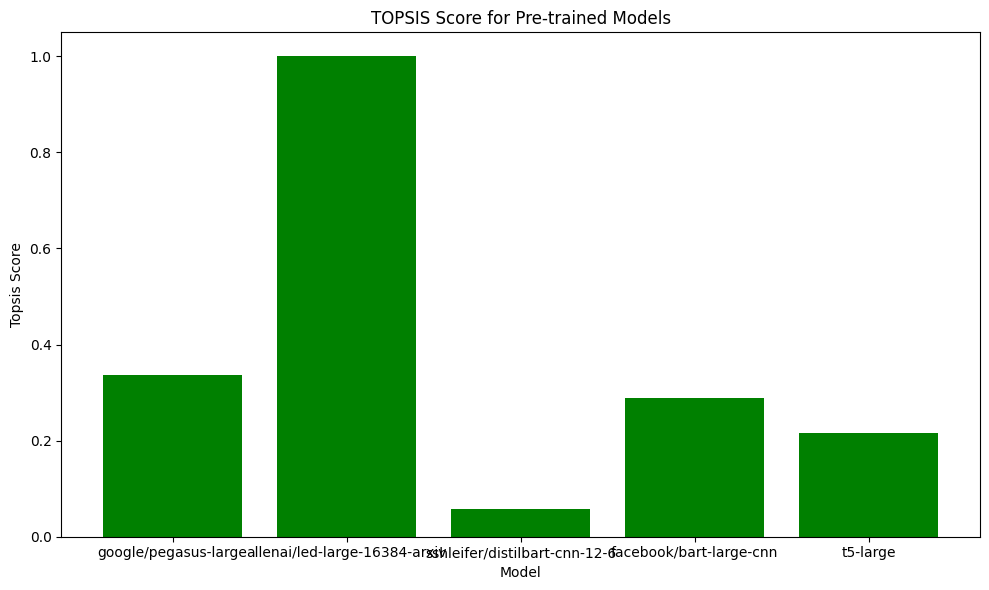

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(final["Model"], final["Topsis Score"], color='green')
plt.xlabel("Model")
plt.ylabel("Topsis Score")
plt.title("TOPSIS Score for Pre-trained Models")
plt.tight_layout()
plt.show()